
Epoch [10/500], Correlation Loss: 1.2455, Independence Loss: 0.1684, Total Loss: 1.2623
Correlations between Level 1 and other levels: [0.08211667835712433, 0.09403648972511292, 0.0995333194732666, 0.07910602539777756, 0.08689269423484802]
Average independence correlations (within levels): [-0.004648742079734802, 0.0014468623325228692, -0.015855018608272077, 0.007782874815165997, -0.017731216188985856, 0.006270526093430817]

Epoch [20/500], Correlation Loss: 0.8252, Independence Loss: 0.1255, Total Loss: 0.8378
Correlations between Level 1 and other levels: [0.21307897567749023, 0.2102193534374237, 0.19412930309772491, 0.1589399129152298, 0.10679995268583298]
Average independence correlations (within levels): [-0.005950277578085661, 0.0011590322479605674, -0.013305254839360714, 0.004254490666789934, -0.013112232217099517, -0.004174692882224917]

Epoch [30/500], Correlation Loss: 0.5283, Independence Loss: 0.0904, Total Loss: 0.5374
Correlations between Level 1 and other levels: [0.331

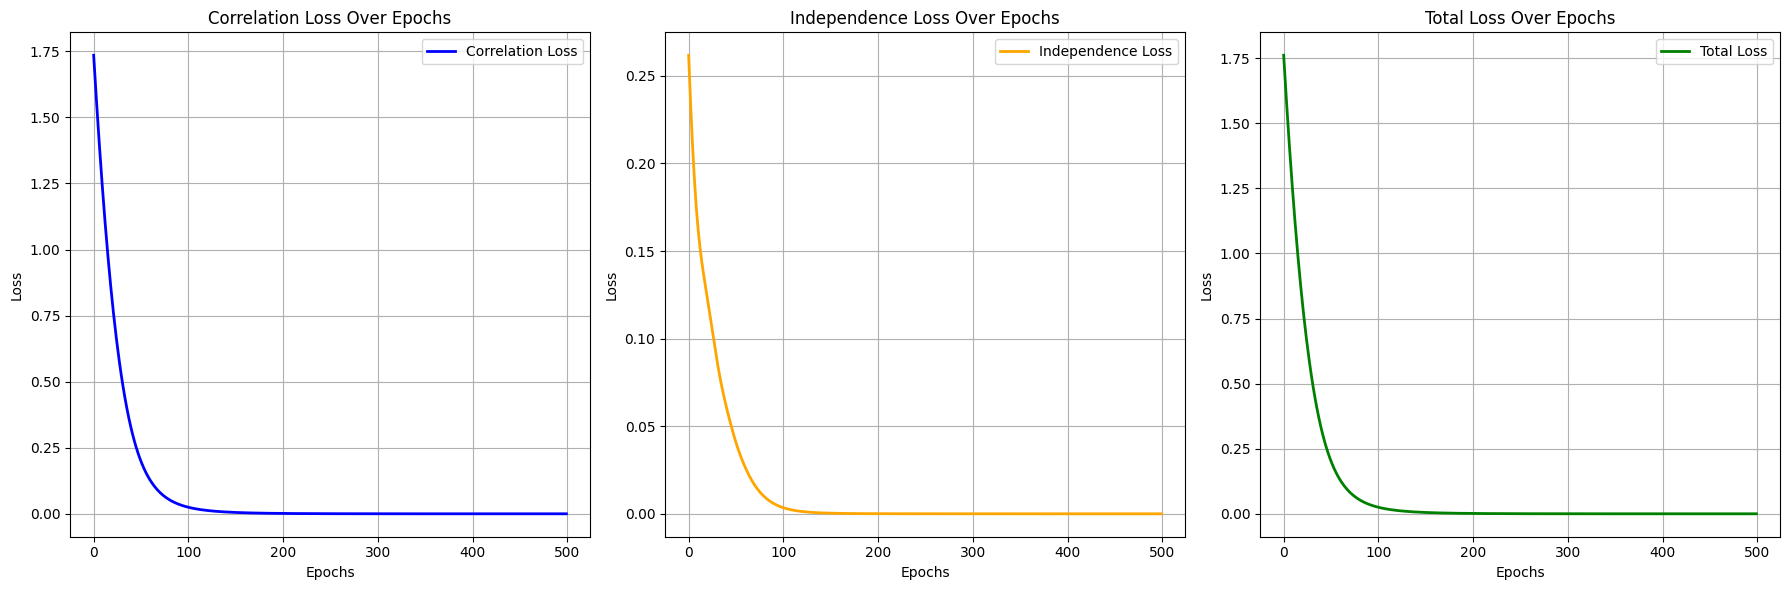

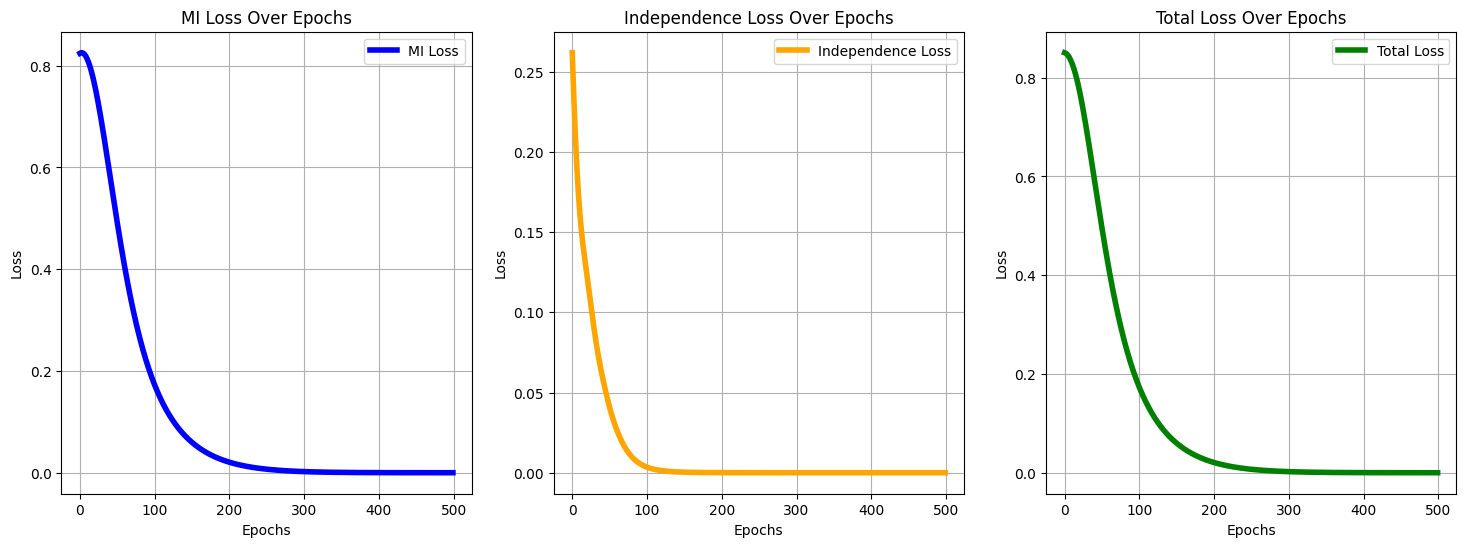

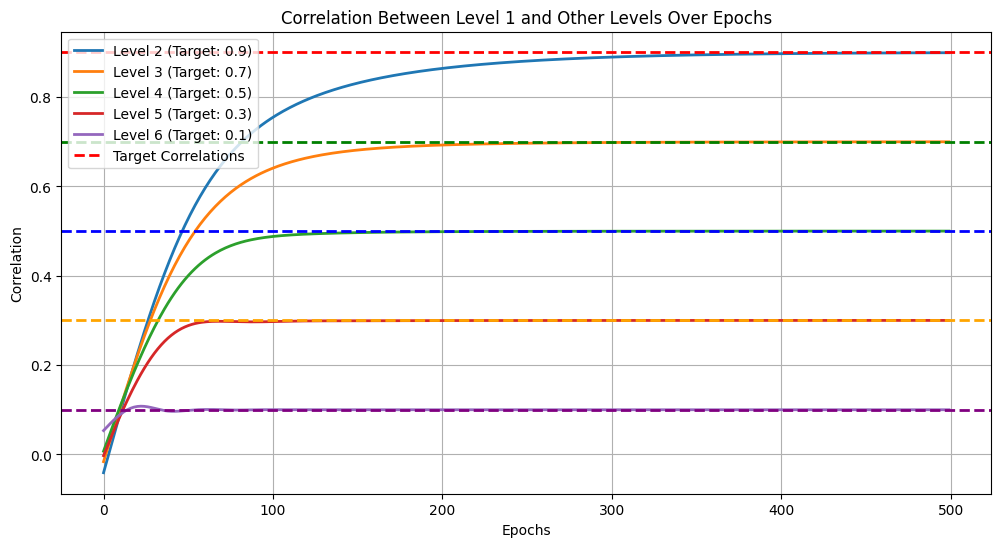

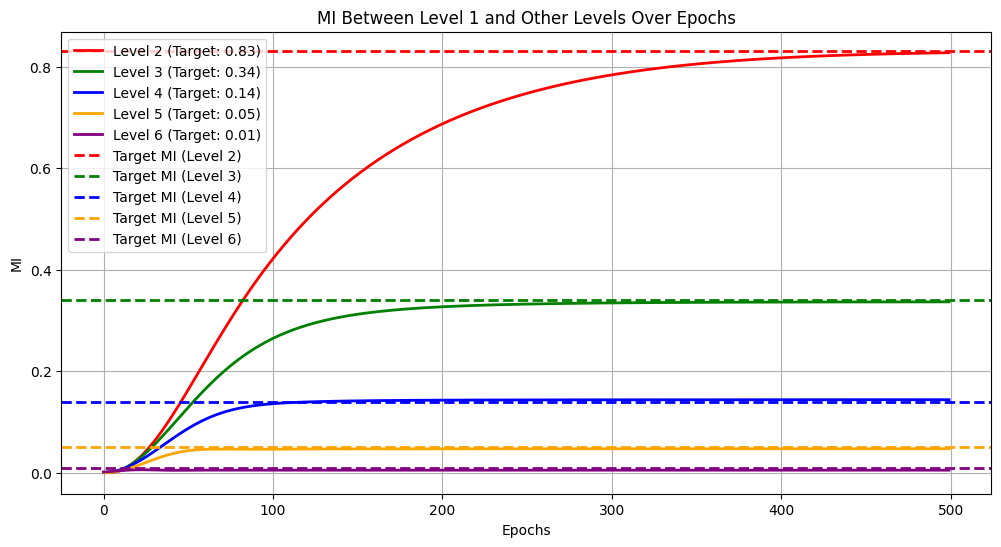

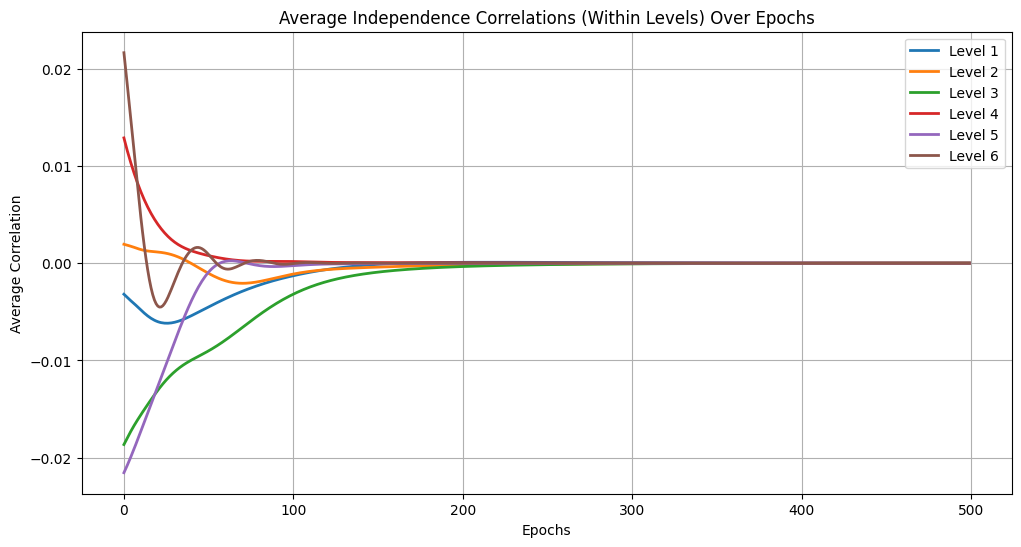

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the target correlations
target_correlations = [0.9, 0.7, 0.5, 0.3, 0.1]

def rho_to_mi(rho, dim):
    result = -dim / 2 * np.log(1 - rho **2)
    return result

##
target_MIs=[]
for rho in target_correlations:
    mi = rho_to_mi(rho,dim=1)
    target_MIs.append(round(mi, 2))



# Define the correlation loss
def correlation_loss(tensor, target_correlations):
    level_1 = tensor[0]  # Level 1
    loss = 0.0
    correlations = []
    MIs=[]
    mi_loss=0
    for i, target_corr in enumerate(target_correlations):
        level_i = tensor[i + 1]  # Other levels
        level_1_flat = level_1.flatten(start_dim=0, end_dim=1)
        level_i_flat = level_i.flatten(start_dim=0, end_dim=1)

        # Compute Pearson correlation
        cov = torch.mean((level_1_flat - level_1_flat.mean()) * (level_i_flat - level_i_flat.mean()))
        std_1 = level_1_flat.std()
        std_i = level_i_flat.std()
        corr = cov / (std_1 * std_i + 1e-8)
        correlations.append(corr.item())  # Store correlation
        loss += (corr - target_corr) ** 2

        ## correlation to MI for plotting only
        target_mi=rho_to_mi(target_corr, dim=1)
        mi=rho_to_mi(corr.detach().numpy(), dim=1)
        MIs.append(mi.item())  # Store correlation
        mi_loss += (mi - target_mi) ** 2


    return loss, correlations, mi_loss

##


# Define the independence loss
def independence_loss(tensor):
    loss = 0.0
    levels, batch_size, features = tensor.shape
    avg_correlations = []
    for level in tensor:
        level_corrs = []
        for i in range(features):
            for j in range(i + 1, features):
                col_i = level[:, i]
                col_j = level[:, j]
                cov = torch.mean((col_i - col_i.mean()) * (col_j - col_j.mean()))
                std_i = col_i.std()
                std_j = col_j.std()
                corr = cov / (std_i * std_j + 1e-8)
                level_corrs.append(corr.item())  # Store correlation
                loss += corr ** 2  # Penalize non-zero correlations
        avg_correlations.append(sum(level_corrs) / len(level_corrs))  # Average correlation for this level
    return loss, avg_correlations

# Define the model
class CorrelationModel(nn.Module):
    def __init__(self, levels, batch_size, features):
        super(CorrelationModel, self).__init__()
        self.levels = levels
        self.batch_size = batch_size
        self.features = features
        self.transform = nn.Parameter(torch.randn(levels, batch_size, features))

    def forward(self):
        return self.transform

# Hyperparameters
levels = 6
batch_size = 256
features = 5
learning_rate = 0.01
num_epochs = 500

# Initialize the model, optimizer, and loss function
model = CorrelationModel(levels, batch_size, features)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Track metrics for plotting
correlation_history = []  # To track correlations between levels
independence_history = []  # To track average independence correlations
mi_history=[]


##
# Initialize lists to track losses
corr_loss_history = []  # To track correlation loss
indep_loss_history = []  # To track independence loss
total_loss_history = []  # To track total loss
total_loss_mi_history=[]
mi_loss_history = []

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model()  # Forward pass

    # Compute the losses
    corr_loss, correlations, mi_loss = correlation_loss(output, target_correlations)
    indep_loss, avg_independence_corrs = independence_loss(output)
    total_loss = corr_loss + 0.1 * indep_loss  # Combine losses with a weighting factor

    # to plot MI not to train
    total_loss_mi = mi_loss + 0.1 * indep_loss

    # Backward pass and optimization
    total_loss.backward()
    optimizer.step()

    # Rho to MI
    mi_list=[]
    for rho in correlations:
        mi = rho_to_mi(rho,dim=1)
        mi_list.append(mi)


    # Track metrics
    correlation_history.append(correlations)  # Correlations between levels
    independence_history.append(avg_independence_corrs)  # Average independence correlations
    mi_history.append(mi_list)  # Correlations between levels

    #
    # Track losses
    corr_loss_history.append(corr_loss.item())
    indep_loss_history.append(indep_loss.item())
    total_loss_history.append(total_loss.item())
    total_loss_mi_history.append(total_loss_mi.item())
    mi_loss_history.append(mi_loss.item())

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"\nEpoch [{epoch + 1}/{num_epochs}], Correlation Loss: {corr_loss.item():.4f}, Independence Loss: {indep_loss.item():.4f}, Total Loss: {total_loss.item():.4f}")
        print(f"Correlations between Level 1 and other levels: {correlations}")
        print(f"Average independence correlations (within levels): {avg_independence_corrs}")


# Plot losses
# Create 3x1 subplots
# Create 1x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Correlation Loss
axs[0].plot(corr_loss_history, label='Correlation Loss', color='blue', linewidth=2)
axs[0].set_title("Correlation Loss Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

# Plot Independence Loss
axs[1].plot(indep_loss_history, label='Independence Loss', color='orange', linewidth=2)
axs[1].set_title("Independence Loss Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid()

# Plot Total Loss
axs[2].plot(total_loss_history, label='Total Loss', color='green', linewidth=2)
axs[2].set_title("Total Loss Over Epochs")
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
axs[2].legend()
axs[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()
##################


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Correlation Loss
axs[0].plot(mi_loss_history, label='MI Loss', color='blue', linewidth=4)
axs[0].set_title("MI Loss Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

# Plot Independence Loss
axs[1].plot(indep_loss_history, label='Independence Loss', color='orange', linewidth=4)
axs[1].set_title("Independence Loss Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid()

# Plot Total Loss
axs[2].plot(total_loss_mi_history, label='Total Loss', color='green', linewidth=4)
axs[2].set_title("Total Loss Over Epochs")
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
axs[2].legend()
axs[2].grid()
############# Convert tracked metrics to tensors for easier plotting
correlation_history = torch.tensor(correlation_history)  # Shape: (num_epochs, len(target_correlations))
independence_history = torch.tensor(independence_history)  # Shape: (num_epochs, levels)
mi_history = torch.tensor(mi_history)


# Plot correlations between levels
plt.figure(figsize=(12, 6))
for i in range(len(target_correlations)):
    plt.plot(correlation_history[:, i], label=f"Level {i + 2} (Target: {target_correlations[i]})", linewidth=2)  # Adjust the linewidth as needed

# Draw horizontal lines with increased linewidth
plt.axhline(y=0.9, color='r', linestyle='--', label="Target Correlations", linewidth=2)
plt.axhline(y=0.7, color='g', linestyle='--', linewidth=2)
plt.axhline(y=0.5, color='b', linestyle='--', linewidth=2)
plt.axhline(y=0.3, color='orange', linestyle='--', linewidth=2)
plt.axhline(y=0.1, color='purple', linestyle='--', linewidth=2)

plt.title("Correlation Between Level 1 and Other Levels Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Correlation")
plt.legend()
plt.grid()
plt.show()

##
plt.figure(figsize=(12, 6))

# Define colors for each level
colors = ['r', 'g', 'b', 'orange', 'purple']  # Corresponding to target MIs

for i in range(len(target_MIs)):
    plt.plot(mi_history[:, i], label=f"Level {i + 2} (Target: {target_MIs[i]})", linewidth=2, color=colors[i])

# Draw horizontal lines with corresponding colors
plt.axhline(y=0.83, color='r', linestyle='--', label="Target MI (Level 2)", linewidth=2)
plt.axhline(y=0.34, color='g', linestyle='--', label="Target MI (Level 3)", linewidth=2)
plt.axhline(y=0.14, color='b', linestyle='--', label="Target MI (Level 4)", linewidth=2)
plt.axhline(y=0.05, color='orange', linestyle='--', label="Target MI (Level 5)", linewidth=2)
plt.axhline(y=0.01, color='purple', linestyle='--', label="Target MI (Level 6)", linewidth=2)

plt.title("MI Between Level 1 and Other Levels Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("MI")
plt.legend()
plt.grid()
plt.show()


# Plot average independence correlations within levels
plt.figure(figsize=(12, 6))
for i in range(levels):
    plt.plot(independence_history[:, i], label=f"Level {i + 1}", linewidth=2)  # Adjust the linewidth as needed

plt.title("Average Independence Correlations (Within Levels) Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Average Correlation")
plt.legend()
plt.grid()
plt.show()